# Homework 3

  - Roman Bachmann, roman.bachmann@epfl.ch
  - Michael Allemann, michael.allemann@epfl.ch
  - Andrea Caforio, andrea.caforio@epfl.ch
  
### Disclaimer: All data sheets are for the entire year 2016

In [1]:
%matplotlib inline

In [2]:
import json
import csv

import pandas as pd
import folium as fl
import numpy as np
import seaborn as sns
import branca.colormap as cm

from matplotlib import pyplot as plt

In [3]:
sns.set()

In [4]:
DATA = './data/'

topo_eu = json.load(open(DATA + 'europe.topojson.json', 'r'))
topo_ch = json.load(open(DATA + 'ch-cantons.topojson.json', 'r'))

# Exercise 1

We choose the definition of unemployment according to the definitions issued by [Eurostat](http://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Unemployed) and [Amstat](https://www.amstat.ch/v2/definition.jsp?lang=de). Concretly, this means the European unemployment rates correspond to the number of unemployed people amongst the active population which is the entire population minus economically inactive like children, students and pensioners. This is the closest definition to how Amstat defines its active population in the above link. The numbers are all based on the year 2016.

[Eurostat](http://ec.europa.eu/eurostat/data/database):
Directory path to used data sheet

    |-- Population and social conditions
        |-- Labour market (labour)
            |-- Employment and unemployment (Labour fource survey)(employ)
                |-- LFS main indicators (lfsi)
                    |-- Unemployment - LFS adjusted series (une)
                        |-- Unemployment by sex and age - annual average (une_rt_a)
                        
[Amstat](https://www.amstat.ch/v2/index.jsp)
Directory path to used data sheet
    
    |-- Details
        |-- 3.1 Durchschnittliche Arbeitslosenquote pro Jahr
            |-- 2016

## Loading and cleaning the Amstat and Eurostat data sheets

In [5]:
eurostat = pd.read_csv(DATA + 'eurostat.csv', usecols=[0, 1, 3, 5])
amstat = pd.read_csv(DATA + 'amstat_total.csv', usecols=[0, 1, 2], encoding='utf-16-le')
capitals = pd.read_csv(DATA + 'capitals.csv', usecols=[0, 1, 2, 3])

# Clean various untidy fields
eurostat.loc[eurostat['GEO'].str.contains('Germany'), 'GEO'] = 'Germany'
eurostat.loc[eurostat['UNIT'].str.contains('active'), 'UNIT'] = 'active'
eurostat.loc[eurostat['UNIT'].str.contains('persons'), 'UNIT'] = 'number'

# Replace missing entries with nan
eurostat['Value'] = eurostat['Value'].str.replace(',', '')
eurostat.Value = eurostat.Value.astype(np.float64)

# Add Switzerland to Eurostat data frame
ch_num = float(amstat.iloc[0, 1].replace("'", '')) / 1000
ch_rate = float(amstat.iloc[0, 2])
rows = [[2016, 'Switzerland', 'number', ch_num], [2016, 'Switzerland', 'active', ch_rate]]
eurostat = eurostat.append(pd.DataFrame(rows, columns=['TIME', 'GEO', 'UNIT', 'Value']), ignore_index=True)
eurostat.head()

,TIME,GEO,UNIT,Value
0,2016,Belgium,number,390.0
1,2016,Belgium,active,7.8
2,2016,Bulgaria,number,247.0
3,2016,Bulgaria,active,7.6
4,2016,Czech Republic,number,212.0


## Bucket distribution

As depicted below the unemployment rates are heavily right skewed. With a majority of values between 3 and 7 percent. To account for this fact we defined the terms **very low unemployment** and **very high unemployment** set them at below 6 percent and above 15 percent respectively. The intervals inbetween are split in equally-sized data classes (**low**, **medium**, **high**) of 3 percent each as shown [here](http://gisgeography.com/choropleth-maps-data-classification/).

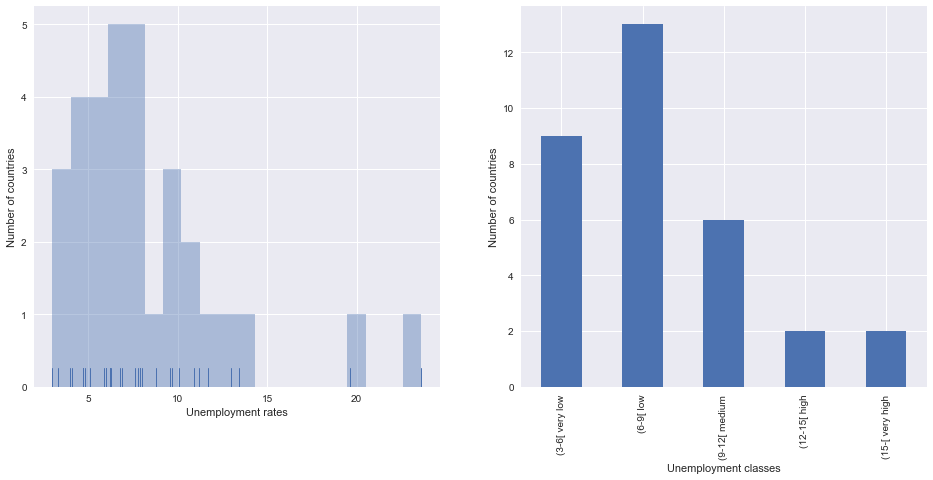

In [6]:
INTERVALS = [[3, 5.99], [6, 8.99], [9, 11.99], [12, 14.99]]

_, axs = plt.subplots(1,2, figsize=(16, 7))
axs[0].set(ylabel='Number of countries')
sns.distplot(eurostat[eurostat.UNIT == 'active'].Value, bins=20, kde=False, rug=True, ax=axs[0], axlabel='Unemployment rates')


buckets = [0, 0, 0, 0, 0]
for _, r in eurostat.iterrows():
    if r.UNIT == 'active':
        for i in range(len(INTERVALS)):
            if r.Value >= INTERVALS[i][0] and r.Value <= INTERVALS[i][1]:
                buckets[i] += 1
                break
            if i == len(INTERVALS)-1:
                buckets[len(buckets)-1] += 1

columns=['(3-6[ very low', '(6-9[ low', '(9-12[ medium', '(12-15[ high', '(15-[ very high']
axs[1].set(xlabel='Unemployment classes', ylabel='Number of countries')
pd.DataFrame([buckets], columns=columns).T.plot(kind='bar', legend=False, ax=axs[1], )

## Visualization

With the help of [ColorBrewer](http://colorbrewer2.org/#type=sequential&scheme=YlOrRd&n=5) we chose 5 highly unambiguous and colorblind safe warm colors for our data buckets, which are then drawn onto the map by the below helper functions. For more information we also added some clickable markers, placed on each country's capital, that show the actual unemployment rate and the total amount of unemployed persons.

Furthermore, we can now classify Switzerland as a country with a **very low** unemployment rate in respect to the other European countries. In fact, only Iceland (3.0%) has lower unemployment rate the Switzerland (3.3%).

In [7]:
COLORS = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
POPUP = '<div>Country: {}</div><br><div>Unemployment Rate: {}</div><br><div>Number of unemployed: {}</div>'

europe = fl.Map([53, 10], tiles='cartodbpositron', zoom_start=4)

# Costum branca colormap legend
legend = cm.StepColormap(COLORS, vmin=3, vmax=25, index=[3, 6, 9, 12, 15], caption='Unemployment rate (%)')
legend.add_to(europe)

def eu_pick_color(topo):
    """Find the corresponding interval and color for a given country and its
    unemployment rate.
    """
    country = topo['properties']['NAME']
    if eurostat.GEO.str.contains(country, regex=False).any():
        for i in range(len(INTERVALS)):
            rate = eurostat.loc[(eurostat.GEO == country) & (eurostat.UNIT == 'active'), 'Value'].values
            if rate >= INTERVALS[i][0] and rate <= INTERVALS[i][1]:
                return COLORS[i]
        
        return COLORS[len(COLORS)-1]
    
def eu_style(topo):
    """Style function for the European choropleth map."""
    return {'fillColor': eu_pick_color(topo), 'weight' : 1, 'color' : 'black', 'fillOpacity': 0.6}

def eu_place_markers():
    """Iterate through all countries in the eurostat data frame and add a marker to the map
    at each country's captial containing the country name, unemployment rate and total number
    of unemployed persons.
    """
    for _, r in eurostat.iterrows():
        capital = capitals[capitals.CountryName == r.GEO]
        rate = eurostat.loc[(eurostat.UNIT == 'active') & (eurostat.GEO == r.GEO), 'Value'].values[0]
        number = eurostat.loc[(eurostat.UNIT == 'number') & (eurostat.GEO == r.GEO), 'Value'].values[0]
        
        popup = fl.Popup(POPUP.format(r.GEO, rate, int(number)*(1000 if r.GEO != 'Iceland' else 1)))

        lat, long = float(capital.CapitalLatitude.values[0]), float(capital.CapitalLongitude.values[0])
        
        fl.RegularPolygonMarker([lat, long], popup=popup, radius=5).add_to(europe)
        
fl.TopoJson(topo_eu, 'objects.europe', eu_style).add_to(europe)
eu_place_markers()

europe.save('europe.html')

# --> [MAP](https://cdn.rawgit.com/qantik/prayingmantissa/folium/homework03/europe.html) Click on markers for detailed information about a country.

# Exercise 2: Focus on Switzerland

## Clarification:

- We did this exercise in the inverse order of what was asked.


- The first map contains the number of unemployed people provided by amstat, which is calculated by dividing the number of unemployed by the size of the active population per canton. It does _not_ include any employed people. It can be found by the following steps:

[Amstat](https://www.amstat.ch/v2/index.jsp)
Directory path to used data sheet:
    
    |-- Arbeitslose
        |-- Details
            |-- 3.1 Durchschnittliche Arbeitslosenquote pro Jahr
                |-- 2016 , Kanton
                


- The second map contains the number of people seeking employment divided by the size of the active population per canton. The datasheet used can be found by the following steps:

[Amstat](https://www.amstat.ch/v2/index.jsp)
Directory path to used data sheet:
    
    |-- Arbeitslose
        |-- Details
            |-- 1.1 Arbeitslose und Stellensuchende nach verschiedenen Kriterien
                |-- Monat(e) auswählen ab 1993
                    |-- Registrierte Stellensuchende
                        |-- Choose all months of 2016

- The third map contains the number of people seeking employment who are currently employed, divided by the size of the active population per canton. The datasheet used can be found by the following steps:

[Amstat](https://www.amstat.ch/v2/index.jsp)
Directory path to used data sheet:
    
    |-- Arbeitslose
        |-- Details
            |-- 1.1 Arbeitslose und Stellensuchende nach verschiedenen Kriterien
                |-- Monat(e) auswählen ab 1993
                    |-- Nicht arbeitslose Stellensuchende
                        |-- Choose all months of 2016


- For each canton we then calculate the mean of the sum of the months of 2016. Amstat only delivers the number of people seeking employment, but what we want is the percentage. To circumvent having to find the size of the active population per canton, we multiply the number of jobseekers and the number of employed jobseekers by the percentage of unemployed and divide by the number of unemployed.


- Unemployment in Switzerland is much lower than in most of the other countries considered in this notebook. The binsizes for the choice of the colors per canton need to be adapted in order to get a visually understandable map. We consider unemployment of 5 percent or higher as being high unemployment in Switzerland and linearly interpolate the remaining four colors for percentages of unemployment between 0 and 5.


- A different colors were used than for the map of Europe above, to stress the fact, that not the same steps were used to classify unemployment.


- The german column names are kept in order to stay consistent with the Amstat website. The added columns are also named using the German language to keep the same style throughout the exercise.


## Preparing the dataframe

- The excel datasheet containing the percentage of unemployed people is loaded and named amstat_canton.


- The names of the cantons of the two dataframes get matched.


- The excel datasheets containing the jobseekers and the employed jobseekers are loaded, whereby only the needed data 
is kept. After dropping the first and the last row, the dataframes need to be reindexed, in order to be able to merge.


- A column is added to the amstat_canton dataframe containing the sum of jobseekers per canton over all months of the year 2016 divided by 12.


- A column is added to the amstat_canton dataframe containing the percentage of jobseekers per canton calculated as explained above in the clarifications.


- The same procedure is done in order to add columns containing the number and the percentage of employed jobseekers.


- The head of the dataframe is displayed, not showing the useless columns 'Metriken' and 'Jahr'.

In [8]:
def rename_amstat_cantons_to_topojson(df):
    """Some cantons don't have the same name in the topojson file and the amstat file.
    Renames the cantons in place, such that they are compatible with the topojson names.
    """
    df.at[df.Kanton == 'Bern','Kanton'] = 'Bern/Berne'
    df.at[df.Kanton == 'Freiburg','Kanton'] = 'Fribourg'
    df.at[df.Kanton == 'Graubünden','Kanton'] = 'Graubünden/Grigioni'
    df.at[df.Kanton == 'Tessin','Kanton'] = 'Ticino'
    df.at[df.Kanton == 'Waadt','Kanton'] = 'Vaud'
    df.at[df.Kanton == 'Wallis','Kanton'] = 'Valais/Wallis'
    df.at[df.Kanton == 'Neuenburg','Kanton'] = 'Neuchâtel'
    df.at[df.Kanton == 'Genf','Kanton'] = 'Genève'

In [9]:
amstat_canton = pd.read_excel(DATA + 'amstat_canton.xlsx')
rename_amstat_cantons_to_topojson(amstat_canton)

jobseekers = pd.read_excel(DATA + 'arbeitsuchende.xlsx') \
    .drop('Monat',axis =1) \
    .drop(0,axis=0) \
    .reset_index() \
    .drop('index',axis=1) \
    .drop(26,axis=0)
    
employed_jobseekers = pd.read_excel(DATA + 'amstat_nicht_arbeitslose_stellensuchende.xlsx') \
    .drop('Monat',axis =1) \
    .drop(0,axis=0) \
    .reset_index() \
    .drop('index',axis=1) \
    .drop(26,axis=0)

amstat_canton['durchschnittliche Anzahl Arbeitsuchende'] = jobseekers.drop('Kanton',axis=1).sum(axis=1) / 12

rate = amstat_canton['durchschnittliche Anzahl Arbeitsuchende'] * amstat_canton['Arbeitslosenquote (1 Nks)']
rate /= amstat_canton['durchschnittliche Anzahl Arbeitslose'].round(decimals=1)
amstat_canton['Arbeitssuchendenquote (1 Nks)'] = rate

amstat_canton['durchschnittliche Anzahl angestellte Stellensuchende'] = employed_jobseekers \
    .drop('Kanton',axis=1) \
    .sum(axis=1) / 12

rate = amstat_canton['durchschnittliche Anzahl angestellte Stellensuchende'] * amstat_canton['Arbeitslosenquote (1 Nks)']
rate /= amstat_canton['durchschnittliche Anzahl Arbeitslose'].round(decimals=1)
amstat_canton['Arbeitssuchendenquote von Angestellten(1 Nks)'] = rate

amstat_canton.drop('Metriken',axis=1).drop('Jahr',axis=1).head()

,Kanton,durchschnittliche Anzahl Arbeitslose,Arbeitslosenquote (1 Nks),durchschnittliche Anzahl Jugendarbeitslose,Jugendarbeitslosenquote (1 Nks),durchschnittliche Anzahl Arbeitslose (älter als 50 Jahre),Arbeitslosenquote 50+ (1 Nks),durchschnittliche Anzahl Arbeitsuchende,Arbeitssuchendenquote (1 Nks),durchschnittliche Anzahl angestellte Stellensuchende,Arbeitssuchendenquote von Angestellten(1 Nks)
0,Zürich,30083.916667,3.7,3711.416667,4.1,7190.750000,3.1,36785.916667,4.524277,6702.000000,0.824275
1,Bern/Berne,15283.166667,2.7,2111.083333,2.9,4224.833333,2.4,20084.250000,3.548175,4801.083333,0.848181
2,Luzern,4601.750000,2.1,757.583333,2.4,1195.833333,1.8,7466.583333,3.407324,2864.833333,1.307347
3,Uri,201.500000,1.0,26.750000,0.9,56.416667,1.0,363.416667,1.803557,161.916667,0.803557
4,Schwyz,1537.166667,1.8,178.083333,1.5,540.666667,2.0,2289.583333,2.681011,752.416667,0.881050


## Visualization

In [10]:
bins = [0.,1.25, 2.5, 3.75 ,5]
COLORS = ['#edf8fb', '#b3cde3', '#8c96c6', '#8856a7', '#810f7c']

step_ch = cm.StepColormap(COLORS, vmin=0, vmax=6, index=bins, caption='')

def interval_ch(val, max_val):
    """Returns the color for a canton, given it's unemployment ratio value and
    the maximum value possible on the map.
    """
    if val>=len(bins):
        return COLORS[-1]
    else:
        return COLORS[int(np.floor(val / max_val * (len(COLORS)-1)))]

def pick_color_ch(topo, df, max_val, column, group=None):
    """Returns the color for the cantons, given the topojson, the data frame and
    the maximum value possible on the map.
    The column decides the type of unemployment ratio we would like to get.
    The group decides if we want to concider Swiss people, foreigners, or an age group.
    """
    canton = topo['properties']['name']
    if df.Kanton.str.contains(canton, regex=False).any():
        if group:
            return interval_ch(float(df[df.Kanton == canton][column][group]), max_val)
        else:
            return interval_ch(float(df[df.Kanton == canton][column]), max_val)
    else:
        return '#555555'

## Unemployment in Swiss cantons

This first map shows the percentage of unemployed people in Switzerland. The highest value is attained in the canton of Jura, which is known to be economically weak in the last years. In the cantons of central Switzerland unemployment is staggeringly small.

In [11]:
switzerland_unemployed = fl.Map([46.8,8.2],tiles= 'cartodbpositron',zoom_start=8)

fl.TopoJson(topo_ch, 'objects.cantons',
    style_function = lambda topo: {
        'fillColor': pick_color_ch(topo, amstat_canton, 5, 'Arbeitslosenquote (1 Nks)'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    }
).add_to(switzerland_unemployed)

legend = cm.StepColormap(COLORS, vmin=0, vmax=6, index=bins, caption= 'Unemployment rate (%)')
legend.add_to(switzerland_unemployed)

switzerland_unemployed.save('unemployed.html')

# --> [MAP](https://cdn.rawgit.com/qantik/prayingmantissa/folium/homework03/unemployed.html)

## Jobseekers (both unemployed and employed) in Swiss cantons

In this map the people who are employed but are nevertheless looking for work are included in the statistics, which leads to an overall hightening of the percentage of people looking for employment. The French and Italian speaking cantons have quite a lot of people looking for employment, but in the Swiss German cantons of Basel City and Schaffhausen also many people are looking for employment.

In [12]:
switzerland_jobseekers = fl.Map([46.8, 8.2],tiles= 'cartodbpositron',zoom_start=8)

fl.TopoJson(topo_ch, 'objects.cantons',
    style_function = lambda topo: {
        'fillColor': pick_color_ch(topo, amstat_canton, 5, 'Arbeitssuchendenquote (1 Nks)'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6}
).add_to(switzerland_jobseekers)

legend = cm.StepColormap(COLORS, vmin=0, vmax=6, index=bins, caption= 'Rate of jobseekers (%)')
legend.add_to(switzerland_jobseekers)

switzerland_jobseekers.save('jobseekers.html')

# --> [MAP](https://cdn.rawgit.com/qantik/prayingmantissa/folium/homework03/jobseekers.html)

## Employed jobseekers in Swiss cantons

To complete the second exercise the difference of the above maps is shown using the same binsizes for the choice of the color. The canton with the highest value of employed jobseekers is Schaffhausen. Besides this canton all have low values of less than 2.5 percent of people who are employed and nevertheless are looking for new employment. 

In [13]:
switzerland_employed_jobseekers = fl.Map([46.8, 8.2],tiles= 'cartodbpositron',zoom_start=8)

fl.TopoJson(topo_ch, 'objects.cantons',
    style_function = lambda topo: {
        'fillColor': pick_color_ch(topo, amstat_canton, 5, 'Arbeitssuchendenquote von Angestellten(1 Nks)'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6}
).add_to(switzerland_employed_jobseekers)

legend = cm.StepColormap(COLORS, vmin=0, vmax=6, index=bins, caption= 'Rate of employed jobseekers (%)')
legend.add_to(switzerland_employed_jobseekers)

switzerland_employed_jobseekers.save('employed_jobseekers.html')

# --> [MAP](https://cdn.rawgit.com/qantik/prayingmantissa/folium/homework03/employed_jobseekers.html)

# 3 Swiss and Foreigners; Young and Old

## Discrepancies in unemployment rate between Swiss and foreign workers
In the last report from the Economic Secretary (SECO) on the state of the employment market, it was noted that there is a discepancy between the unemployment rate of foreign workers and swiss workers. To analyze this difference, we decided to plot one Choropleth map each for the unemployment rate of Swiss workers, foreign workers, as well as the difference between the two.



[Amstat](https://www.amstat.ch/v2/index.jsp) Directory path to used data sheet:
    
    |-- Arbeitslose
        |-- Details
            |-- 3.1 Durchschnittliche Arbeitslosenquote pro Jahr
                |-- 2016 , Kanton , Nationalität
            
In the "amstat_nationality.xlsx" Excel file, the averages of the year 2016 are given. For each canton, we get the total number and ratios of unemployed Swiss people and foreigners in the categories for general unemployment, youth unemployment and unemployment of people over 50 years old.

Unemployment in Switzerland is much lower than in most of the other countries considered in this notebook. The binsizes for the choice of the colors per canton need to be adapted in order to get a visually understandable map. Because of the higher foreign unemployment rates, we decided to adjust the bins in regard to the previous exercise. Most of the unemployment ratios fall between 0 and 8, while there are some strong outliers like Jura that have unemployment rates for young foreigners as high as 14.4%. We consider unemployment of 8 percent or higher as being high unemployment (given the nationality and age groups) in Switzerland and linearly interpolate the remaining four colors for percentages of unemployment between 0 and 14.4.

### Preparing the Data Frames

By pivoting the "Nationalität" column, we can get columns for each unemployment ratio for Swiss people and foreigners.
To calculate the difference in unemployment ratios, we subtract the swiss unemployment rate from the always higher foreigner unemployment rate for each canton.

In [14]:
amstat_nat = pd.read_excel(DATA + 'amstat_nationality.xlsx', header=2)
amstat_nat = amstat_nat[['Kanton', 'Nationalität', 'Arbeitslosenquote (1 Nks)', 'Jugendarbeitslosenquote (1 Nks)', 'Arbeitslosenquote 50+ (1 Nks)']]

rename_amstat_cantons_to_topojson(amstat_nat)

amstat_nat = amstat_nat.pivot(index='Kanton', columns='Nationalität')
amstat_nat.reset_index(inplace=True)
amstat_nat['foreigner_swiss_diff'] = amstat_nat['Arbeitslosenquote (1 Nks)']['Ausländer'] - amstat_nat['Arbeitslosenquote (1 Nks)']['Schweizer']
amstat_nat.head()

Kanton Arbeitslosenquote (1 Nks)            \
Nationalität                                         Ausländer Schweizer   
0                             Aargau                       6.2       2.2   
1             Appenzell Ausserrhoden                       3.9       1.4   
2              Appenzell Innerrhoden                       3.9       0.7   
3                   Basel-Landschaft                       5.4       2.3   
4                        Basel-Stadt                       5.3       2.9   

             Jugendarbeitslosenquote (1 Nks)            \
Nationalität                       Ausländer Schweizer   
0                                        5.8       2.5   
1                                        4.4       1.4   
2                                        8.2       0.7   
3                                        5.0       2.7   
4                                        5.7       4.0   

             Arbeitslosenquote 50+ (1 Nks)           foreigner_swiss_diff  
Nationalität                     Ausländer Schweizer                       
0                                      6.5       2.1                  4.0  
1                                      4.4       1.5                  2.5  
2                                      5.1       0.8                  3.2  
3                                      5.5       2.1                  3.1  
4                                      5.9       2.2                  2.4

In [15]:
amstat_canton = pd.read_excel(DATA + 'amstat_canton.xlsx')
rename_amstat_cantons_to_topojson(amstat_canton)

amstat_arbeitssuchende = pd.read_excel(DATA + 'arbeitsuchende.xlsx').drop('Monat',axis =1)\
                        .drop(0,axis=0).reset_index().drop('index',axis=1).drop(26,axis=0)
    
amstat_canton['durchschnittliche Anzahl Arbeitsuchende'] = amstat_arbeitssuchende.drop('Kanton',axis=1).sum(axis=1)/12

amstat_canton['Arbeitssuchendenquote (1 Nks)'] = (amstat_canton['durchschnittliche Anzahl Arbeitsuchende']*\
                        amstat_canton['Arbeitslosenquote (1 Nks)']/amstat_canton['durchschnittliche Anzahl Arbeitslose'])\
                        .round(decimals=1)

amstat_canton.drop('Metriken',axis=1).drop('Jahr',axis=1).head()

,Kanton,durchschnittliche Anzahl Arbeitslose,Arbeitslosenquote (1 Nks),durchschnittliche Anzahl Jugendarbeitslose,Jugendarbeitslosenquote (1 Nks),durchschnittliche Anzahl Arbeitslose (älter als 50 Jahre),Arbeitslosenquote 50+ (1 Nks),durchschnittliche Anzahl Arbeitsuchende,Arbeitssuchendenquote (1 Nks)
0,Zürich,30083.916667,3.7,3711.416667,4.1,7190.750000,3.1,36785.916667,4.5
1,Bern/Berne,15283.166667,2.7,2111.083333,2.9,4224.833333,2.4,20084.250000,3.5
2,Luzern,4601.750000,2.1,757.583333,2.4,1195.833333,1.8,7466.583333,3.4
3,Uri,201.500000,1.0,26.750000,0.9,56.416667,1.0,363.416667,1.8
4,Schwyz,1537.166667,1.8,178.083333,1.5,540.666667,2.0,2289.583333,2.7


## Visualization

In [16]:
swiss_foreigners = fl.Map([46.8, 8.2], tiles = 'cartodbpositron', zoom_start=8)

bins_nat = [0., 2, 4, 6, 8]
step_ch_nat = cm.StepColormap(COLORS, vmin=0, vmax=14.4, index=bins_nat, caption='Unemployment rate (%)')

swiss_unemployed = fl.TopoJson(topo_ch, overlay=False,name='Unemployed Swiss', object_path='objects.cantons',
    style_function = lambda topo: {
        'fillColor': pick_color_ch(topo, amstat_nat, 8, 'Arbeitslosenquote (1 Nks)', 'Schweizer'), 'fillOpacity': 0.6
    }
)
fl.TileLayer('cartodbpositron').add_to(swiss_unemployed)

foreigners_unemployed = fl.TopoJson(topo_ch, overlay=False, name='Unemployed Foreigners', object_path='objects.cantons',
    style_function = lambda topo: {
        'fillColor': pick_color_ch(topo, amstat_nat, 8, 'Arbeitslosenquote (1 Nks)', 'Ausländer'), 'fillOpacity': 0.6
    }
)
fl.TileLayer('cartodbpositron').add_to(foreigners_unemployed)

diff_unemployed = fl.TopoJson(topo_ch, overlay=False, name='Difference', object_path='objects.cantons',
    style_function = lambda topo: {
        'fillColor': pick_color_ch(topo, amstat_nat, 8, 'foreigner_swiss_diff'), 'fillOpacity': 0.6
    }
)
fl.TileLayer('cartodbpositron').add_to(diff_unemployed)

swiss_unemployed.add_to(swiss_foreigners)
foreigners_unemployed.add_to(swiss_foreigners)
diff_unemployed.add_to(swiss_foreigners)

step_ch_nat.add_to(swiss_foreigners)
fl.LayerControl(collapsed=False).add_to(swiss_foreigners)

swiss_foreigners.save('foreigners.html')

# --> [MAP](https://cdn.rawgit.com/qantik/prayingmantissa/folium/homework03/foreigners.html)
## Folium 🐞: When map is first loaded all layers are displayed at the same time. Click on layer control tab to correct it.

Comparing the "Unemployed Swiss" and "Unemployed Foreigners" maps above, it becomes very apparent how in all cantons the unemployment ratio of foreigners is much higher than the one of Swiss people. Looking at the "Difference" map, we see how big this difference is. Jura has a particulary high difference of unemployment between Swiss people and foreigners!

## Incorporating Youth and 50+ unemployment rates

Below, for each canton we display a barplot of the unemployment ratios of 4 different social groups, namely:

* Young foreigners (blue)
* Young Swiss (green)
* Swiss over 50 (red)
* Foreigners over 50 (violet)

We observe that Appenzell Innerrhoden, Jura, Neuchâtel and Wallis have very high unemployment ratios for foreigners, while in all those cantons, the unemployment ratios of Swiss people are mostly less than half as high! With some exceptions (Geneva and Ticino), this trend can be seen in every canton.

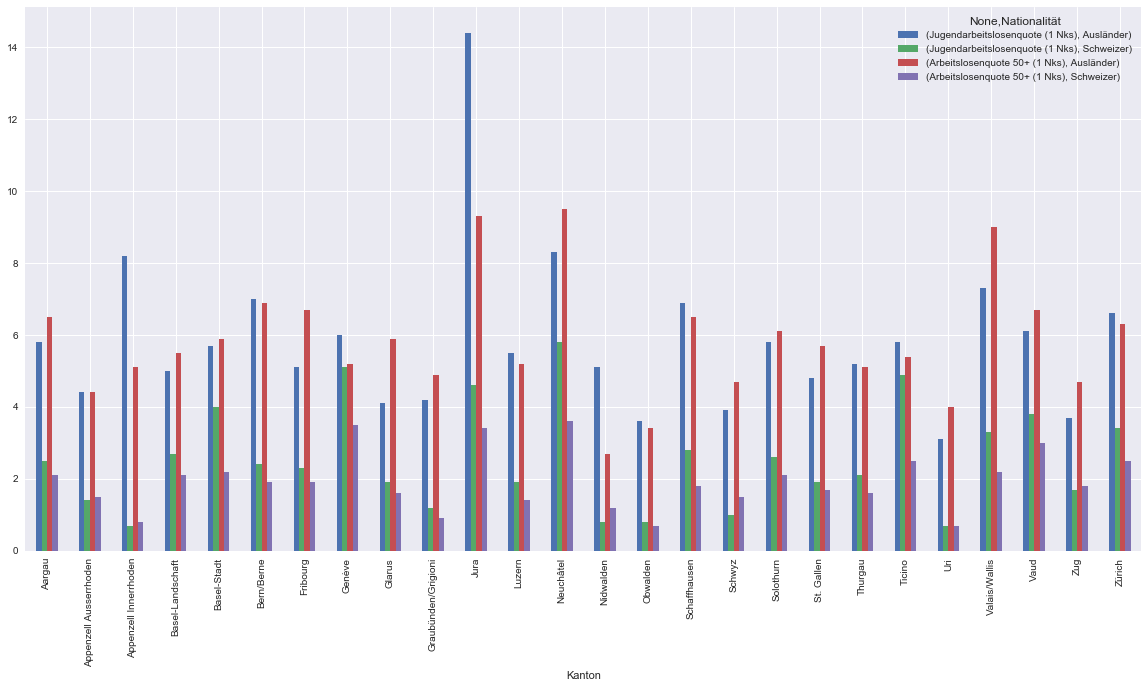

In [17]:
amstat_nat_ages = amstat_nat[['Kanton', 'Jugendarbeitslosenquote (1 Nks)','Arbeitslosenquote 50+ (1 Nks)']]
amstat_nat_ages = amstat_nat_ages.set_index("Kanton")
amstat_nat_ages.plot(kind='bar', figsize=(20,10))

## Discrepancies in unemployment rate between different age groups

Now we also take an additional look at the third age group of workers, namely the ones between 25 and 49 years old.


[Amstat](https://www.amstat.ch/v2/index.jsp) Directory path to used data sheet:
    
    |-- Arbeitslose
        |-- Details
            |-- 3.1 Durchschnittliche Arbeitslosenquote pro Jahr
                |-- 2016 , Kanton , Altersklassen 15-24, 25-49, 50 und mehr
            
            
In the "amstat_age.xlsx" Excel file, the averages of the year 2016 are given. For each canton, we get the total number and ratios of unemployed people in the age categories 15-24, 25-49, 50+.

### Preparing the Data Frame

By pivoting the "Age group" column, we can get columns for each unemployment ratio for the age categories "15-24 years", "25-49 years" and "50+".

In [18]:
amstat_age = pd.read_excel(DATA + 'amstat_age.xlsx', header=2)
amstat_age = amstat_age.rename(columns = {'Unnamed: 3':'Age group'})
amstat_age = amstat_age[['Kanton', 'Arbeitslosenquote (1 Nks)', 'Age group']]

rename_amstat_cantons_to_topojson(amstat_age)

amstat_age = amstat_age.pivot(index='Kanton', columns='Age group')
amstat_age.head()

Arbeitslosenquote (1 Nks)                        
Age group                            15-24 Jahre 25-49 Jahre 50 und mehr
Kanton                                                                  
Aargau                                       3.2         3.3         2.8
Appenzell Ausserrhoden                       1.7         1.8         1.8
Appenzell Innerrhoden                        1.1         1.0         1.2
Basel-Landschaft                             3.1         3.2         2.6
Basel-Stadt                                  4.5         4.1         3.1

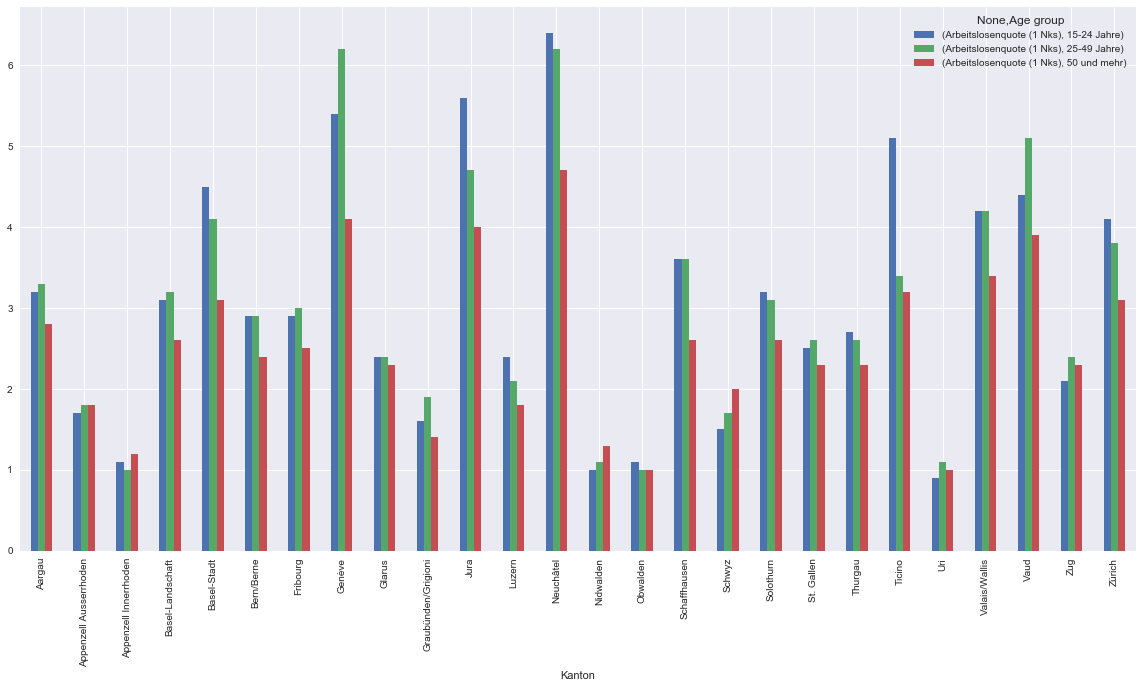

In [19]:
amstat_age.plot(kind='bar', figsize=(20,10))

In most cantons, the people between 15 and 24 have the highest unemployment ratios, followed by the 25 to 49 year olds and the people over 50.

# Exercise 4: Bonus

By calculating a weighted average over the two **Röstigraben** regions, whereby the Romandie contains the cantons Vaud, Jura, Neuchâtel, Valais and Genève, we get a significant difference in unemployment rates as shown below and in the subsequent map.

In [20]:
rest = amstat_canton.iloc[:21]
romandie = amstat_canton.iloc[21:]

avg_rest = rest['durchschnittliche Anzahl Arbeitslose'] * rest['Arbeitslosenquote (1 Nks)']
avg_romandie = romandie['durchschnittliche Anzahl Arbeitslose'] * romandie['Arbeitslosenquote (1 Nks)']
rate_rest = avg_rest.sum() / rest['durchschnittliche Anzahl Arbeitslose'].sum()
rate_romandie = avg_romandie.sum() / romandie['durchschnittliche Anzahl Arbeitslose'].sum()
print('Romandie:', rate_romandie)
print('Rest:', rate_rest)

Romandie: 4.932387756927949
Rest: 3.070845835366212


In [21]:
df_roestigraben = amstat_canton.copy()

a = [rate_rest] * 21
b = [rate_romandie] * 5

df_roestigraben['Arbeitslosenquote (1 Nks)'] = a + b

roestigraben = fl.Map([46.8,8.2],tiles= 'cartodbpositron',zoom_start=8)

fl.TopoJson(topo_ch, 'objects.cantons',
    style_function = lambda topo: {
        'fillColor': pick_color_ch(topo, df_roestigraben, 5, 'Arbeitslosenquote (1 Nks)'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    }
).add_to(roestigraben)

roestigraben.save('roestigraben.html')

# --> [MAP](https://cdn.rawgit.com/qantik/prayingmantissa/folium/homework03/roestigraben.html)